# Preprocessing Steps
1. Define bad and dead channels
    - note: manual inspection first? The authors seemed to go in loops and find the bad channels after all the preprocessing are done (artifacts found in autorejects and IC rejections)
For (each participant):
2. Downsample (1000Hz -> 250Hz)
    - note: original data has 260Hz low pass filter
3. Bandpass Filter (0.1, 30Hz)
4. Remove 50Hz. Original paper: notch Filter (50Hz (48, 52, 1))
5. Remove bad channels (if more than 4: remove participant)
6. Rerefenrence (mastoid)
7. Isolate some data to run ICA (epoching? starting with each new cue)
8. Remove bad trials (find artifacts)
9. Run ICA
10. Perform auto-rejection per ICLabel
11. Interpolation

>NOTE: two-pass preprocessing: go through the preprocessing steps once and then see if there is still bad channels remaining. if so, mark them and start over again.

**NOTES**
- nonLearners = [3 5 9 12 20 24 25 29 30 32 33]

In [298]:
import mne
from mne_bids import (BIDSPath,read_raw_bids)
from meegkit.dss import dss_line
import sys
sys.path.insert(0,'.')
import os
import ccs_eeg_utils
from matplotlib import pyplot as plt
import numpy as np
from find_trial_artifact import find_artifacts

# Load the dataset

In [251]:
bids_root = "/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset"
subject_id = '27'

bids_path = BIDSPath(subject=subject_id, task='casinos',
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)

Extracting parameters from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-27/eeg/sub-27_task-casinos_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-27/eeg/sub-27_task-casinos_events.tsv.
The event "Stimulus" refers to multiple event values.Creating hierarchical event names.
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  4
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  5
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_4526/4234231732.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 27
date: 18-Mar-2022 13:55:40
handedness: R
order: 50-50 mixed 80-20
stimuli: a lemon an orange
  raw = read_raw_bids(bids_path)


In [307]:
### Examine the raw data, manually mark the bad channels?
raw.plot()
#raw.get_data()  # extract data as numpy
raw.load_data()  # load to memory

qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass


Using pyopengl with version 3.1.10


<RawBrainVision | sub-27_task-casinos_eeg.eeg, 31 x 3161620 (3161.6 s), ~747.8 MiB, data loaded>

# Set the Montage

In [253]:
#NOTE: download .locs file from author's Github, put it under root_of_dataset/code/..
locs_filename = 'site2channellocations.locs'
locs_path = os.path.join(bids_root, 'code', locs_filename)      
custom_montage = mne.channels.read_custom_montage(locs_path)
raw.set_montage(custom_montage, match_case=False)

<RawBrainVision | sub-27_task-casinos_eeg.eeg, 31 x 3161620 (3161.6 s), ~747.8 MiB, data loaded>

# Downsample

In [254]:
new_sfreq = 250
eeg_down = raw.copy().resample(new_sfreq, npad='auto')
print(f"Original Sampling Rate: {raw.info['sfreq']} Hz")
print(f"New Sampling Rate: {eeg_down.info['sfreq']} Hz")

Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz


# Bandpass

In [255]:
f_low = 0.5
f_high = 30

# manipulate the cutoff frequencies if needed
eeg_band = eeg_down.copy().filter(l_freq=f_low, h_freq=f_high)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (6.604 s)



# Remove 50Hz Noise

## Option 1: Notch filter

Original setting:  `EEG = pop_eegfiltnew(EEG, 48, 52,[],1)`

In [256]:
eeg_band_notch = eeg_band.copy().notch_filter(50)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



## Option 2: Zapline filter

In [257]:
# input & output of dss_line are of shape: (n_samples, n_channels, n_trial)

eeg_band_zap = eeg_band.copy()
band_sfreq = eeg_band.info['sfreq']
eeg_band_zap_array, _ = dss_line(np.expand_dims(eeg_band.get_data().T, axis=2), fline=50, sfreq=band_sfreq)
# convert back to shape: (n_channels, n_samples)
eeg_band_zap_array = eeg_band_zap_array.squeeze().T
eeg_band_zap._data = eeg_band_zap_array

#NOTE: when applied on the downsample eeg (not band filtered), zapline does remove the peak at 50Hz
# eeg_band_zap = eeg_down.copy()
# band_sfreq = eeg_down.info['sfreq']
# eeg_band_zap_array, _ = dss_line(np.expand_dims(eeg_down.get_data().T, axis=2), fline=50, sfreq=band_sfreq)
# # convert back to shape: (n_channels, n_samples)
# eeg_band_zap_array = eeg_band_zap_array.squeeze().T
# eeg_band_zap._data = eeg_band_zap_array

Power of components removed by DSS: 0.00


# Examine the Effect of Filtering

Effective window size : 2.048 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
sfreqs:
 raw      : 1000.0 -> Nyq 500.0
 down     : 250.0 -> Nyq 125.0
 band     : 250.0 -> Nyq 125.0
 band_notch    : 250.0 -> Nyq 125.0
 band_zap    : 250.0 -> Nyq 125.0
orig          power @ 49.8Hz: -126.6 dB,  @ 200.2Hz: -140.2 dB
down          power @ 50.0Hz: -120.8 dB,  @ 125.0Hz: -141.3 dB
band          power @ 50.0Hz: -174.4 dB,  @ 125.0Hz: -182.5 dB
band_notch    power @ 50.0Hz: -174.7 dB,  @ 125.0Hz: -182.5 dB
band_zap      power @ 50.0Hz: -174.5 dB,  @ 125.0Hz: -182.5 dB


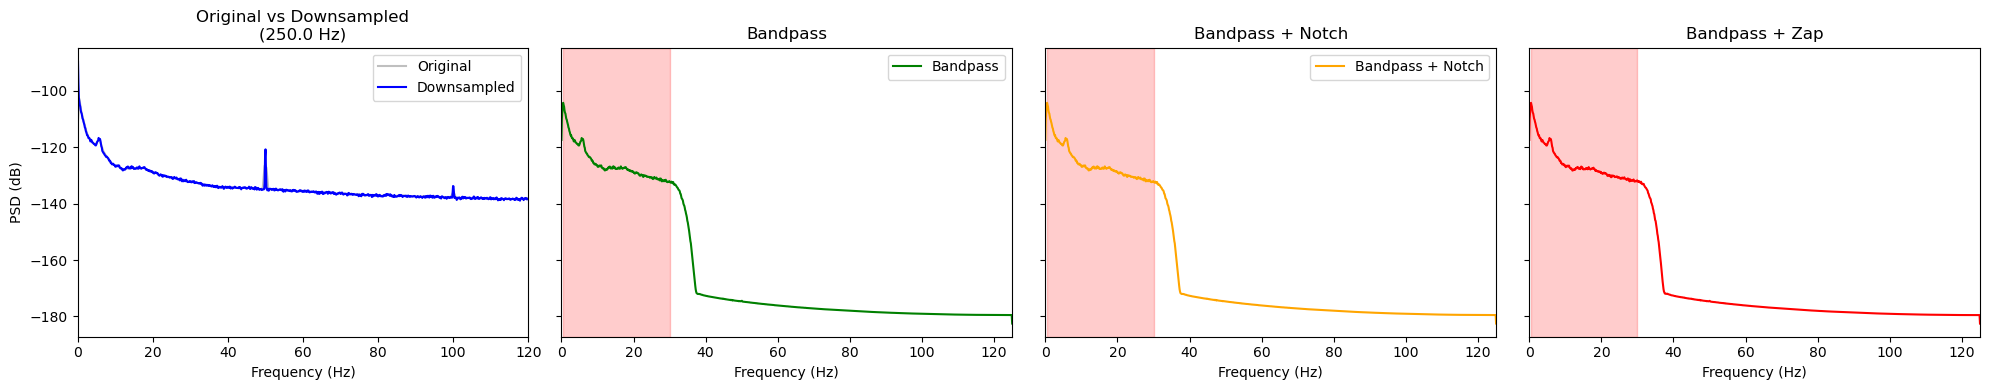

In [204]:
picks = ['FCz']

# Compute PSDs (Spectrum objects)
psd_orig = raw.compute_psd(picks=picks)
psd_down = eeg_down.compute_psd(picks=picks)
psd_band = eeg_band.compute_psd(picks=picks)
psd_band_notch = eeg_band_notch.compute_psd(picks=picks)
psd_band_zap = eeg_band_zap.compute_psd(picks=picks)

# Extract freqs & dB PSDs separately for each
freqs_orig = psd_orig.freqs
p_orig_db = 10 * np.log10(psd_orig.get_data()[0])

freqs_down = psd_down.freqs
p_down_db = 10 * np.log10(psd_down.get_data()[0])

freqs_band = psd_band.freqs
p_band_db = 10 * np.log10(psd_band.get_data()[0])

freqs_band_notch = psd_band_notch.freqs
p_band_notch_db = 10 * np.log10(psd_band_notch.get_data()[0])

freqs_band_zap = psd_band_zap.freqs
p_band_zap_db = 10 * np.log10(psd_band_zap.get_data()[0])


# --- Diagnostic: print sampling rates and Nyquist ---
print("sfreqs:")
print(" raw      :", raw.info['sfreq'], "-> Nyq", raw.info['sfreq'] / 2)
print(" down     :", eeg_down.info['sfreq'], "-> Nyq", eeg_down.info['sfreq'] / 2)
print(" band     :", eeg_band.info['sfreq'], "-> Nyq", eeg_band.info['sfreq'] / 2)
print(" band_notch    :", eeg_band_notch.info['sfreq'], "-> Nyq", eeg_band_notch.info['sfreq'] / 2)
print(" band_zap    :", eeg_band_zap.info['sfreq'], "-> Nyq", eeg_band_zap.info['sfreq'] / 2)

# --- Diagnostic: find power at/near 50 Hz and 200 Hz for each PSD ---
def power_at(freqs, psd_db, target_hz):
    idx = np.argmin(np.abs(freqs - target_hz))
    return freqs[idx], psd_db[idx]

for name, freqs, psd_db in [
    ("orig", freqs_orig, p_orig_db),
    ("down", freqs_down, p_down_db),
    ("band", freqs_band, p_band_db),
    ("band_notch", freqs_band_notch, p_band_notch_db),
    ("band_zap", freqs_band_zap, p_band_zap_db)
]:
    f50, p50 = power_at(freqs, psd_db, 50)
    f200, p200 = power_at(freqs, psd_db, 200)
    print(f"{name:12s}  power @ {f50:.1f}Hz: {p50:.1f} dB,  @ {f200:.1f}Hz: {p200:.1f} dB")

# --- Plot: each PSD with its own x-axis (keeps things aligned) ---
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)

axes[0].plot(freqs_orig, p_orig_db, label='Original', color='gray', alpha=0.5)
axes[0].plot(freqs_down, p_down_db, label='Downsampled', color='blue')
axes[0].set_title(f'Original vs Downsampled\n({eeg_down.info["sfreq"]} Hz)')
axes[0].set_xlim(0, 120)
axes[0].set_xlabel('Frequency (Hz)'); axes[0].set_ylabel('PSD (dB)')
axes[0].legend()

axes[1].plot(freqs_band, p_band_db, label='Bandpass', color='green')
axes[1].axvspan(f_low, f_high, color='red', alpha=0.2)
axes[1].set_title('Bandpass')
axes[1].set_xlim(0, min(300, freqs_band.max()))
axes[1].set_xlabel('Frequency (Hz)'); axes[1].legend()

axes[2].plot(freqs_band_notch, p_band_notch_db, label='Bandpass + Notch', color='orange')
axes[2].axvspan(f_low, f_high, color='red', alpha=0.2)
axes[2].set_title('Bandpass + Notch')
axes[2].set_xlim(0, min(300, freqs_band_notch.max()))
axes[2].set_xlabel('Frequency (Hz)'); axes[2].legend()

axes[3].plot(freqs_band_zap, p_band_zap_db, label='Bandpass + Zap', color='red')
axes[3].axvspan(f_low, f_high, color='red', alpha=0.2)
axes[3].set_title('Bandpass + Zap')
axes[3].set_xlim(0, min(300, freqs_band_notch.max()))
axes[3].set_xlabel('Frequency (Hz)'); axes[2].legend()

plt.tight_layout()
plt.show()


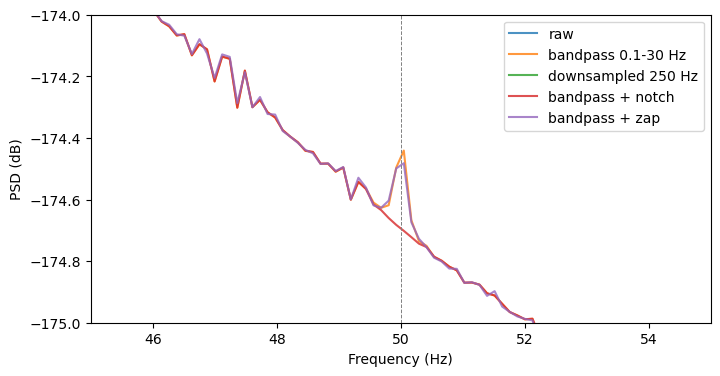

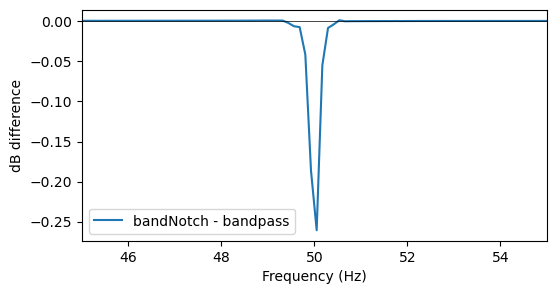

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(freqs_orig, p_orig_db, label='raw', alpha=0.8)
ax.plot(freqs_band, p_band_db,  label='bandpass 0.1-30 Hz', alpha=0.8)
ax.plot(freqs_down, p_down_db,  label='downsampled 250 Hz', alpha=0.8)
ax.plot(freqs_band_notch, p_band_notch_db,  label='bandpass + notch', alpha=0.8)
ax.plot(freqs_band_zap, p_band_zap_db, label='bandpass + zap', alpha=0.8)
ax.set_xlim(45, 55)           # look up to Nyquist of original or 120 Hz
ax.set_ylim(-175,-174)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (dB)')
ax.legend()
ax.axvline(50, color='gray', linestyle='--', linewidth=0.7)
plt.show()

# Zoom near 50 Hz
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(freqs_down, p_band_notch_db - p_band_db, label='bandNotch - bandpass')
ax.set_xlim(45, 55); ax.set_xlabel('Frequency (Hz)'); ax.set_ylabel('dB difference')
ax.axhline(0, color='k', linewidth=0.5)

ax.legend()
plt.show()


*Q: Which one to choose?*

# Cleaning in Time (Trial Rejection)

In [ ]:
# split the data into tirals (starts from the onset of fixation thingy)
evts, evts_dict = mne.events_from_annotations(eeg_band_zap)
evts_dict_stim = {k: evts_dict[k] for k in evts_dict.keys() if k in ['Stimulus:S  1', 'Stimulus:S 11', 'Stimulus:S 21', 'Stimulus:S 31']}
trials = mne.Epochs(eeg_band_zap, evts, evts_dict_stim, tmin=-0, tmax=3, baseline=(0, 0))    #NOTE: from 0s to 3s. maybe extend the window?

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
Not setting metadata
432 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [300]:
print(trials.get_data().shape)

Using data from preloaded Raw for 432 events and 751 original time points ...
0 bad epochs dropped
(432, 31, 751)


In [ ]:
#NOTE: parameters used are the same as the author, may consider changing them
is_artifacts = np.any(find_artifacts(trials), axis=1).squeeze()
# get the indices of trials of artifacts
is_artifacts_idx = np.where(is_artifacts)[0]
#print(len(is_artifacts_idx))

# drop bad trials
trials.drop(is_artifacts_idx)

Using data from preloaded Raw for 432 events and 751 original time points ...
Dropped 34 epochs: 90, 190, 192, 230, 233, 234, 235, 240, 261, 266, 268, 270, 272, 273, 277, 278, 279, 280, 282, 283, 284, 285, 286, 287, 310, 313, 316, 327, 328, 330, 331, 332, 333, 335


<Epochs | 398 events (all good), 0 – 3 s (baseline 0 – 0 s), ~42 KiB, data not loaded,
 np.str_('Stimulus:S  1'): 143
 np.str_('Stimulus:S 11'): 59
 np.str_('Stimulus:S 21'): 62
 np.str_('Stimulus:S 31'): 134>

# Re-reference (after removing bad channels)

In [309]:
# placeholder

# ICA analysis

Difference between 3 ICA methods:
- Runica
- Picard
- Fastica

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Using data from preloaded Raw for 398 events and 751 original time points ...


/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_4526/1216260994.py:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(trials,verbose=True)


Selecting by non-zero PCA components: 31 components
Using data from preloaded Raw for 398 events and 751 original time points ...
Fitting ICA took 15.8s.


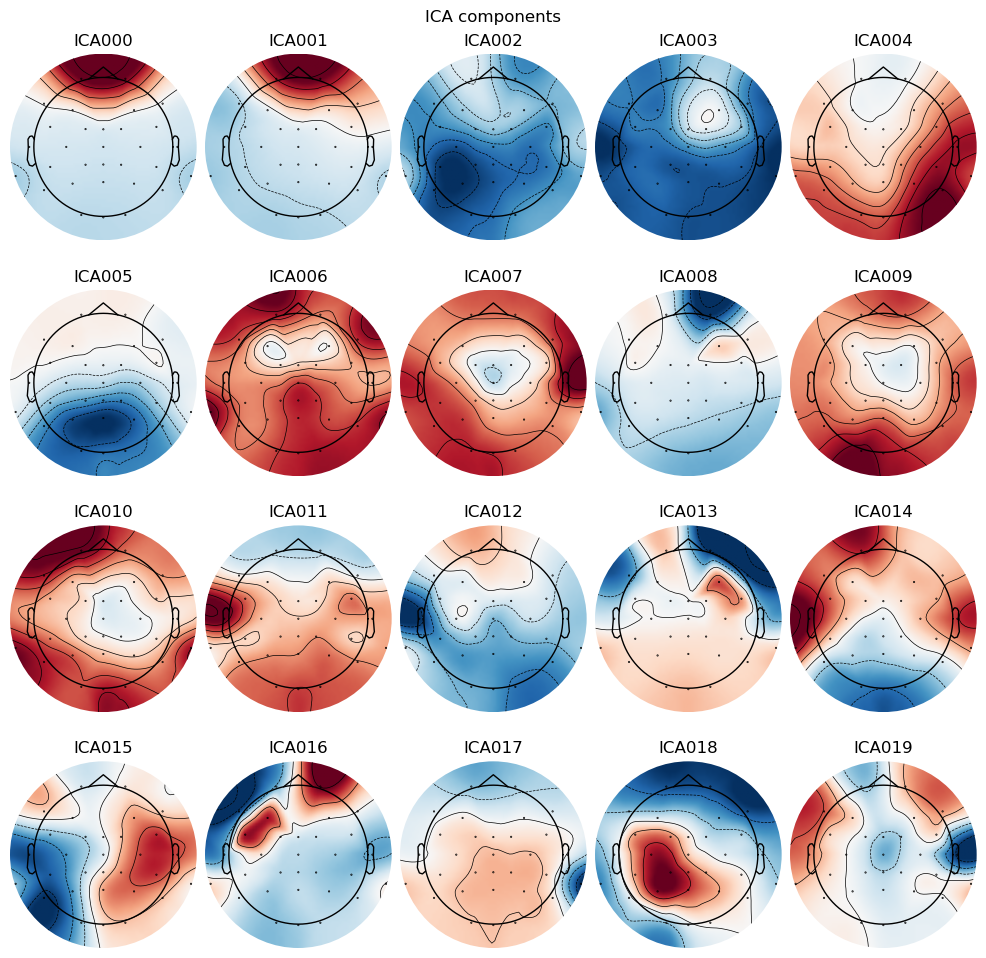

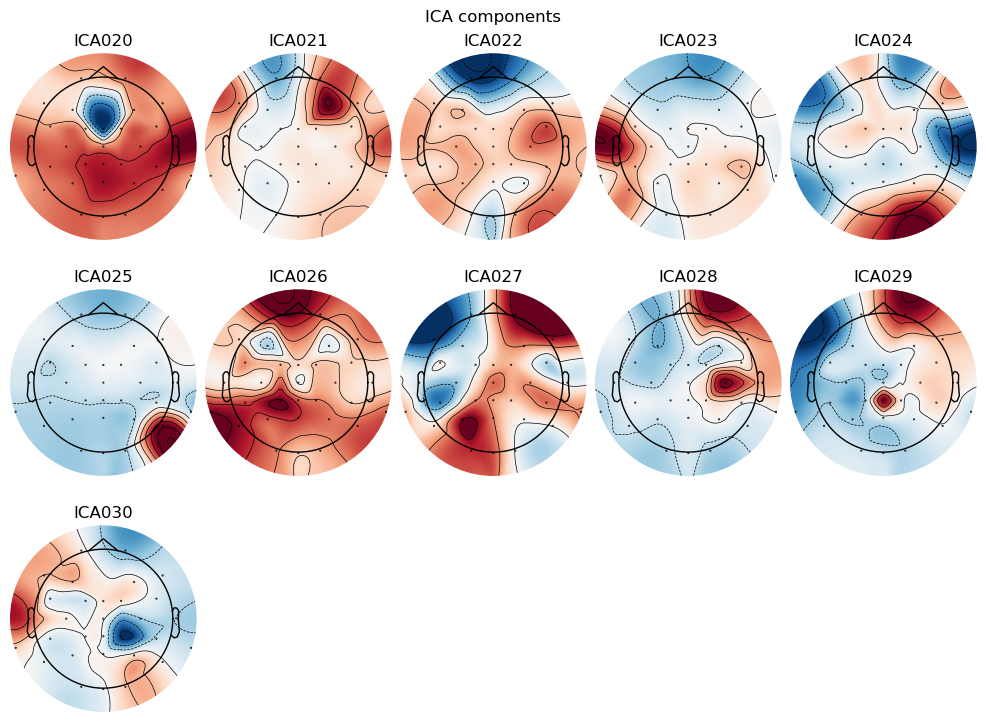

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x731.5 with 11 Axes>]

In [ ]:
ica = mne.preprocessing.ICA(method="picard")
ica.fit(trials,verbose=True)
ica.plot_components()

Using data from preloaded Raw for 398 events and 751 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
398 matching events found
No baseline correction applied
0 projection items activated


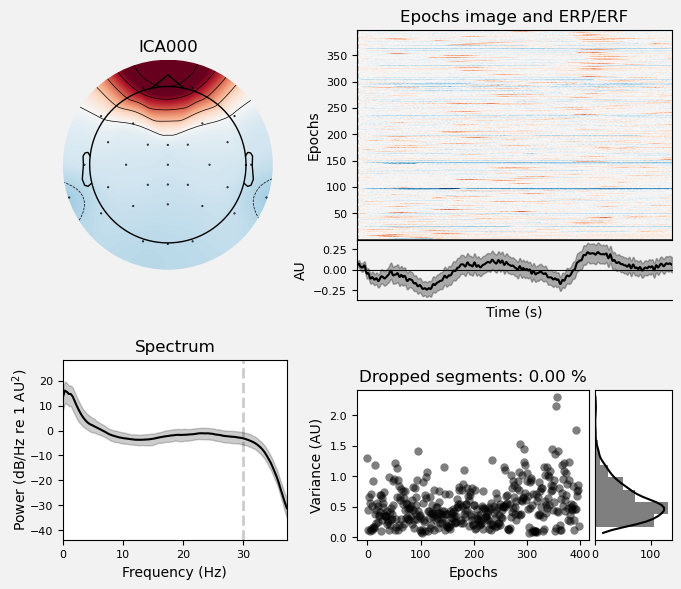

[<Figure size 700x600 with 6 Axes>]

In [ ]:
#NOTE: manual inspection. We are using automatic IC rejection?
ica.plot_properties(trials,picks=[0])